In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data
from torchvision import datasets, transforms
# from torchvision.utils import save_image

from vae_conv_mnist import conv_variational_autoencoder 
import matplotlib.pyplot as plt 
import sys, os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)   

In [3]:
channels = 1
# batch_size = cm_train.shape[0]/100
conv_layers = 4
feature_maps = [64,64,64,64]
filter_shapes = [3,3,3,3]
strides = [1,2,1,1]
dense_layers = 2
dense_neurons = [128, 64]
dense_dropouts = [0.0, 0.0]
latent_dim = 20

image_size = train_loader.dataset.train_data.shape[1]

In [4]:
autoencoder = conv_variational_autoencoder(image_size,channels,conv_layers,feature_maps,
                                           filter_shapes,strides,dense_layers,dense_neurons,dense_dropouts,latent_dim)

In [5]:
epochs = 50
log_interval = 200 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(1, epochs + 1): 
    autoencoder.train(train_loader, epoch) 
    autoencoder.test(test_loader, epoch) 
    
#     with torch.no_grad(): 
#         train_all = train_loader.dataset.train_data.reshape(-1, 1, 28, 28).float()[:2000].to(device)
# #         print(train_all.shape)
#         decoded = autoencoder.predict(train_all) 
#         embeded = autoencoder.return_embeddings(train_all) 
#         encoded = autoencoder.encode(train_all) 
    
#     plt.figure(figsize=(10,8))
#     plt.scatter(embeded.cpu()[:2000,0], embeded.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10') 
#     plt.title('Epoch: %d' % epoch)
#     plt.colorbar() 
#     plt.savefig('./results/3_result_epoch%d.pdf' % epoch) 

Train Epoch: 1 [0/60000 (0%)]	Loss: 469.405273
Train Epoch: 1 [6400/60000 (11%)]	Loss: 205.381516
Train Epoch: 1 [12800/60000 (21%)]	Loss: 172.821518
Train Epoch: 1 [19200/60000 (32%)]	Loss: 151.244354
Train Epoch: 1 [25600/60000 (43%)]	Loss: 133.701202
Train Epoch: 1 [32000/60000 (53%)]	Loss: 138.249863
Train Epoch: 1 [38400/60000 (64%)]	Loss: 118.703323
Train Epoch: 1 [44800/60000 (75%)]	Loss: 132.674347
Train Epoch: 1 [51200/60000 (85%)]	Loss: 118.623093
Train Epoch: 1 [57600/60000 (96%)]	Loss: 121.013847
====> Epoch: 1 Average loss: 150.9879 ====> Test set loss: 119.1473
Train Epoch: 2 [0/60000 (0%)]	Loss: 122.072731
Train Epoch: 2 [6400/60000 (11%)]	Loss: 115.345398
Train Epoch: 2 [12800/60000 (21%)]	Loss: 117.211868
Train Epoch: 2 [19200/60000 (32%)]	Loss: 108.095306
Train Epoch: 2 [25600/60000 (43%)]	Loss: 105.817535
Train Epoch: 2 [32000/60000 (53%)]	Loss: 115.263153
Train Epoch: 2 [38400/60000 (64%)]	Loss: 105.515259
Train Epoch: 2 [44800/60000 (75%)]	Loss: 104.111099
Train Ep

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad(): 
    train_all = train_loader.dataset.train_data.reshape(-1, 1, 28, 28).float()[:2000].to(device)
    print(train_all.shape)
    decoded = autoencoder.predict(train_all) 
    embeded = autoencoder.return_embeddings(train_all) 
    encoded = autoencoder.encode(train_all) 

torch.Size([2000, 1, 28, 28])


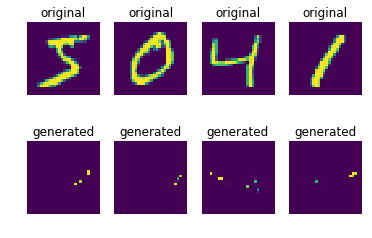

In [12]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(nrows=2, ncols=4) 

for i in range(4): 
    ax[0,i].imshow(np.squeeze(train_all.cpu())[i]) 
    ax[0,i].set_title('original')
    ax[1,i].imshow(np.squeeze(decoded.cpu())[i]) 
    ax[1,i].set_title('generated')
    ax[0,i].axis('off') 
    ax[1,i].axis('off')
plt.show()

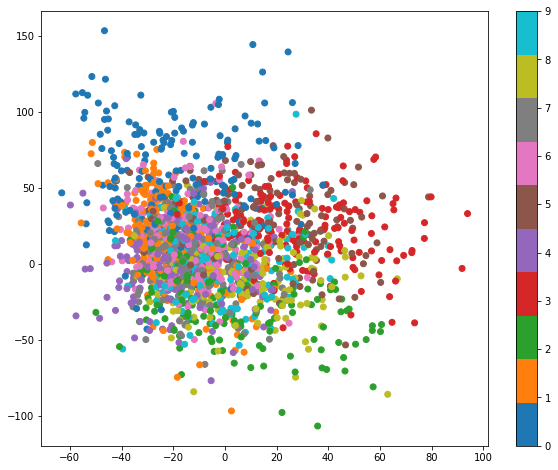

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(embeded.cpu()[:2000,0], embeded.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10')
plt.colorbar() 
# plt.xlim((-500, 500))
# plt.ylim((-500, 500))